# Data Analysis of Job tasks
When taking into account the occupation and when not taking into account the occupation, using machine learning methods such as text clustering and tokenization

Name: Joshua Hizgiaev<br>
Research: SIAI

In [5]:
%pip install nltk
%pip install transformers
%pip install seaborn
%pip install pandas numpy scipy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Add standard data science pacakges
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load google drive with excel sheet
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# load excel sheet data into google colab
path = '/content/drive/MyDrive/Data/Task Statements.xlsx'
task_excel = pd.DataFrame(pd.read_excel(path))
task_csv = task_excel.to_csv("/content/drive/MyDrive/Data/Task_Statements.csv",index=None,header=True)
df = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Data/Task_Statements.csv"))
print(df.shape[0])
df.head()

19265


,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent


# Preprocessing:
1. Getting rid of unneeded columns
2. Getting rid of duplicates if any
3. Getting rid of missing values if any
4. Convert dates to date time python objects

In [7]:
df = df.drop(['O*NET-SOC Code','Task ID','Domain Source'],axis=1).drop_duplicates().dropna(how='all')
df['Date'] = pd.to_datetime(df.Date,format='%m/%Y')
df['Date'] = df['Date'].dt.strftime('%m-%Y')
print(df.shape[0])
df.head()

19265


,Title,Task,Task Type,Incumbents Responding,Date
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014


In [8]:
# Find the total amount of tasks that are core, supplemental, or neither
# this will help in understanding how the data was made, as well as what majority of the data is place or
# if it is evenly distributed
core_df = df[df['Task Type'] == 'Core']
supp_df = df[df['Task Type'] == 'Supplemental']
neither_df = df[df['Task Type'].isna()]
print("The number of tasks identified as core: {}".format(core_df.shape[0]))
print("The number of tasks identified as supplemental: {}".format(supp_df.shape[0]))
print("The number of tasks identified as neither core or supplemental: {}".format(neither_df.shape[0]))
core_df.reset_index(drop=True, inplace=True)
supp_df.reset_index(drop=True, inplace=True)
neither_df.reset_index(drop=True, inplace=True)

The number of tasks identified as core: 13225
The number of tasks identified as supplemental: 4728
The number of tasks identified as neither core or supplemental: 1312


### It is clear that there is an uneven number of core, supplemental, and tasks classified as neither
I now need to determine how exactly I should utilize this data, and how to approach it with NLP. I will first begin with **NOT** concidering occupation, meaning that I will only need to perform similarity clustering for tasks only. With that decided, I will perform NLP with the following data:
1. The data as a whole
2. The data of supplemental tasks
3. The data of core tasks
4. The data of tasks classified as neither (not core or supplemental basically)

To do so, I need to develop a Natural Language Processing model with pytorch that will allow me to create clusters based on the similarity of tasks and apply a label to each task. Meaning I will group tasks based on their similarity by assigning a numerical label to each task, every task with the same label will be in the same cluster!

In [9]:
# preprocess text data for NLP, I will begin with taking into
# account the WHOLE dataset, and then will work on core, supplemental, and neither later
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

X = df['Task'].tolist()

documents = []
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
for sen in range(0,len(X)):
  # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)

df['Processed Tasks'] = np.array(documents)
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...
...,...,...,...,...,...,...
19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...
19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...
19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...
19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA


vectorizer = TfidfVectorizer()
processed_text = df['Processed Tasks'].tolist()
X = vectorizer.fit_transform(processed_text)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

k = 21
kmeans = KMeans(n_clusters = k,init='k-means++',max_iter=300,n_init=15, random_state=42)
kmeans.fit(X_pca)
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)
df['Labels'] = kmeans.labels_
clusters = kmeans.labels_.tolist()
texts_df = pd.DataFrame({'text':processed_text,'cluster':clusters})
texts_df

The average silhouette_score is : -0.005196494531411029


,text,cluster
0,direct or coordinate an organization financial...,18
1,appoint department head or manager and assign ...,0
2,analyze operation to evaluate performance of c...,18
3,direct plan or implement policy objective or a...,18
4,prepare budget for approval including those fo...,6
...,...,...
19260,unload car containing liquid by connecting hos...,13
19261,clean interior of tank car or tank truck using...,17
19262,lower gauge rod into tank or read meter to ver...,13
19263,operate conveyor and equipment to transfer gra...,5


In [51]:
texts_df.to_excel('/content/drive/MyDrive/Data/output.xlsx')
X_pca.shape

(19265, 2)

In [26]:
%matplotlib inline

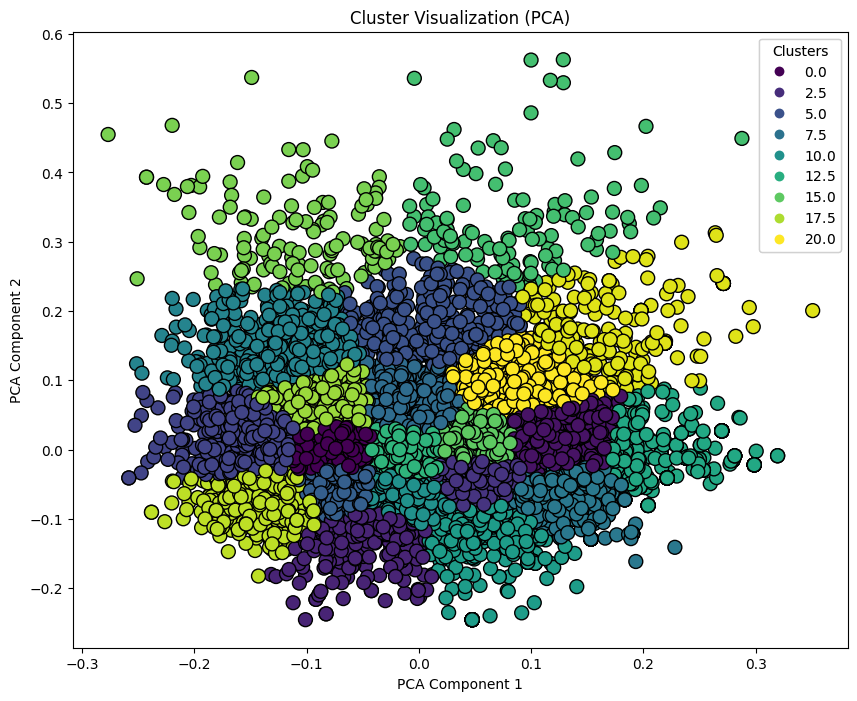

In [53]:
pca_df = pd.DataFrame(data=X_pca, columns=["PCA1", "PCA2"])
pca_df["cluster"] = clusters
plt.figure(figsize=(10, 8))
ax = plt.gca()
scatter = ax.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["cluster"], cmap="viridis", edgecolors='k', s=100)
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
ax.add_artist(legend1)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization (PCA)")
plt.show()

### Now that task statements are assigned cluster labels I now want to do text classification to appoint every task description one of the following categories:

1. Technical/Engineering: Tasks involving designing, testing, and installation of devices, software, or complex equipment.

2. Management/Leadership: Tasks related to directing, overseeing, and organizing teams, projects, or departments.

3. Administrative: Tasks associated with scheduling, record-keeping, data entry, and reporting.

4. Marketing/Sales: Tasks related to promoting, selling, and creating demand for products or services.

5. Customer Service: Tasks involving interacting with customers, resolving concerns, and providing support.

6. Research/Analysis: Tasks related to gathering information, conducting studies, and evaluating findings.

7. Production: Tasks focused on manufacturing, assembly, and operations of products or machines.

8. Quality Assurance/Control: Tasks related to ensuring quality, adherence to standards, and improvement activities.

9. Human Resources: Tasks dealing with recruitment, hiring, employee relations, and training.

10. Finance/Accounting: Tasks focused on financial management, budgeting, and revenues.

11. Information Technology: Tasks associated with managing and maintaining digital systems, networks, and databases.

12. Maintenance/Repair: Tasks involving the upkeep and repair of equipment, buildings, or machinery.

13. Logistics/Supply chain: Tasks related to managing inventory, transportation, and distribution.

14. Creative/Design: Tasks involving design, creation, and innovation in various fields such as art, graphics, or products.

15. Education/Training: Tasks focused on teaching, mentoring, and skill development.

16. Health/Medical: Tasks related to patient care, treatment, and medical procedures.

17. Legal/Compliance: Tasks associated with ensuring adherence to laws and regulations.

18. Project Management: Tasks focused on planning, execution, and delivery of projects.

19. Security/Safety: Tasks related to the protection of people, property, or information.

20. Environment/Sustainability: Tasks focused on conservation, waste management, and eco-friendly processes.

# How does one do this?

Well I have the cluster labels, all I really need to do is go through the data and place the labels myself!

In [55]:
from transformers import pipeline

categories = [
    "TE, designing, testing, and installation of devices, software, or complex equipment",
    "Management/Leadership, directing, overseeing, and organizing teams, projects, or departments",
    "Administrative, scheduling, record-keeping, data entry, and reporting",
    "Marketing/Sales, promoting, selling, and creating demand for products or services",
    "Customer Service, interacting with customers, resolving concerns, and providing support",
    "Research, gathering information, conducting studies, and evaluating findings",
    "Production, manufacturing, assembly, and operations of products or machines",
    "Quality Assurance/Control, ensuring quality, adherence to standards, and improvement activities",
    "HR, recruitment, hiring, training, employee relations",
    "Finance/Accounting, financial management, budgeting, and revenues",
    "IT, managing and maintaining digital systems, networks, and databases",
    "Maintenance/Repair, upkeep and repair of equipment, buildings, or machinery.",
    "Logistics/Supply chain, managing inventory, transportation, and distribution",
    "Creative/Design, design, creation, and innovation in various fields such as art, graphics, or products",
    "Education/Training, teaching, mentoring, and skill development",
    "Health/Medical, patient care, treatment, and medical procedures",
    "Legal/Compliance, ensuring adherence to laws and regulations",
    "Project Management, planning, execution, and delivery of projects",
    "Security/Safety, protection of people, property, or information",
    "Environment/Sustainability, conservation, waste management, and eco-friendly processes",
    "Data Science/Analysis, perform data analysis and evaluation and create machine learning models"
]

nlp = pipeline("zero-shot-classification", device=0)
# Function to categorize descriptions
def categorize_description(description: str) -> str:
    result = nlp(description, categories,multi_label=False)
    return result["labels"][0]
df["category"] = df["Processed Tasks"].apply(categorize_description)
df.to_excel('/content/drive/MyDrive/Data/category_output.xlsx')
df

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...,18,"Finance/Accounting, financial management, budg..."
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...,0,"Management/Leadership, directing, overseeing, ..."
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...,18,"Research, gathering information, conducting st..."
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...,18,"Management/Leadership, directing, overseeing, ..."
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...,6,"Finance/Accounting, financial management, budg..."
...,...,...,...,...,...,...,...,...
19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...,13,"Logistics/Supply chain, managing inventory, tr..."
19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...,17,"Maintenance/Repair, upkeep and repair of equip..."
19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...,13,"Maintenance/Repair, upkeep and repair of equip..."
19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...,5,"Logistics/Supply chain, managing inventory, tr..."


### Now we have accuratley labled labeled job tasks corresponding to time series, now we can finally perform some standard analysis! Starting with frequency, distribution, and growth of frequency over time.

In [10]:
# In order to skip fine tuning one shot classification again I will simply assign the excel sheet generated and work on
# analysis from here
path = '/content/drive/MyDrive/Data/category_output.xlsx'
cat_df = pd.DataFrame(pd.read_excel(path))
cat_df

,Unnamed: 0,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
0,0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...,18,"Finance/Accounting, financial management, budg..."
1,1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...,0,"Management/Leadership, directing, overseeing, ..."
2,2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...,18,"Research, gathering information, conducting st..."
3,3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...,18,"Management/Leadership, directing, overseeing, ..."
4,4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...,6,"Finance/Accounting, financial management, budg..."
...,...,...,...,...,...,...,...,...,...
19260,19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...,13,"Logistics/Supply chain, managing inventory, tr..."
19261,19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...,17,"Maintenance/Repair, upkeep and repair of equip..."
19262,19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...,13,"Maintenance/Repair, upkeep and repair of equip..."
19263,19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...,5,"Logistics/Supply chain, managing inventory, tr..."


In [25]:
# Create a mapping to replace the really long descriptions:
cat_mapping = {
    "TE, designing, testing, and installation of devices, software, or complex equipment":'Technical/Engineering',
    "Management/Leadership, directing, overseeing, and organizing teams, projects, or departments":'Management/Leadership',
    "Administrative, scheduling, record-keeping, data entry, and reporting":'Administrative',
    "Marketing/Sales, promoting, selling, and creating demand for products or services":'Marketing/Sales',
    "Customer Service, interacting with customers, resolving concerns, and providing support":'Customer Service',
    "Research, gathering information, conducting studies, and evaluating findings":'Research',
    "Production, manufacturing, assembly, and operations of products or machines":'Production',
    "Quality Assurance/Control, ensuring quality, adherence to standards, and improvement activities":'Quality Assurance',
    "HR, recruitment, hiring, training, employee relations":'Human Relations',
    "Finance/Accounting, financial management, budgeting, and revenues":'Finance/Accounting',
    "IT, managing and maintaining digital systems, networks, and databases":'Information Technology',
    "Maintenance/Repair, upkeep and repair of equipment, buildings, or machinery.":'Maintenance/Repair',
    "Logistics/Supply chain, managing inventory, transportation, and distribution":'Logistics/Supply Chain',
    "Creative/Design, design, creation, and innovation in various fields such as art, graphics, or products":'Creative/Design',
    "Education/Training, teaching, mentoring, and skill development":'Education/Training',
    "Health/Medical, patient care, treatment, and medical procedures":'Health/Medical',
    "Legal/Compliance, ensuring adherence to laws and regulations":'Legal/Compliance',
    "Project Management, planning, execution, and delivery of projects":'Project Management',
    "Security/Safety, protection of people, property, or information":'Security/Safety',
    "Environment/Sustainability, conservation, waste management, and eco-friendly processes":'Environment/Sustainability',
    "Data Science/Analysis, perform data analysis and evaluation and create machine learning models":'Data Science/Analysis'
}
cat_df['category'] = cat_df['category'].replace(cat_mapping)
freq_df = cat_df.groupby(['Title','Date','category']).size().reset_index(name='Frequency')
freq_df

,Title,Date,category,Frequency
0,Accountants and Auditors,11-2020,Administrative,5
1,Accountants and Auditors,11-2020,Customer Service,2
2,Accountants and Auditors,11-2020,Finance/Accounting,5
3,Accountants and Auditors,11-2020,Legal/Compliance,6
4,Accountants and Auditors,11-2020,Management/Leadership,2
...,...,...,...,...
6525,Zoologists and Wildlife Biologists,08-2018,Administrative,1
6526,Zoologists and Wildlife Biologists,08-2018,Environment/Sustainability,1
6527,Zoologists and Wildlife Biologists,08-2018,Legal/Compliance,1
6528,Zoologists and Wildlife Biologists,08-2018,Management/Leadership,1


# Frequency Analysis:
We have tasks with labels within a time series, now we can do the following:
- For the purposes of this analysis, we will be focusing on 3 key categories:
  - Technical/Engineering
  - Data Science/Analysis
  - Research

We will start by calculating its descriptive statistics for each data point, we will then do the same for the rest of the categories, then we will perform both a P-test and a T-test to compare to categorical data points. After which, we will begin plotting individual frequency distribution over time to clearly see how task types are changing. For our purposes we will be combining Research and Data Science in one plot as there is an extreme amount of overlap in there similarties.



In [22]:
category_data = pd.DataFrame(columns=['Mean', 'STD', 'Min','Max','Median','Harmonic Mean', 'Geometric Mean'])

# It should be noted that this gets the data without taking into account the year, so it will get its stats over all avaliable time points
def add_stats(category_name):
  '''Will add a row of descriptive statistics based on category name to the category_data dataframe'''
  cat_data = freq_df[freq_df['category']==category_name]
  mean_frequency = cat_data['Frequency'].mean()
  std_frequency = cat_data['Frequency'].std()
  min_frequency = cat_data['Frequency'].min()
  max_frequency = cat_data['Frequency'].max()
  harmonic_mean_freq = sp.stats.hmean(cat_data['Frequency'])
  geometric_mean = sp.stats.gmean(cat_data['Frequency'])
  median = np.median(cat_data['Frequency'])
  category_data.loc[category_name] = [mean_frequency,std_frequency,min_frequency,max_frequency,median,harmonic_mean_freq,geometric_mean]

for item in cat_mapping.values():
  add_stats(item)

category_data


,Mean,STD,Min,Max,Median,Harmonic Mean,Geometric Mean
Technical/Engineering,2.321429,1.988106,1.0,11.0,2.0,1.494047,1.794856
Management/Leadership,1.932945,1.294904,1.0,9.0,2.0,1.444440,1.640455
Administrative,1.496314,1.161518,1.0,13.0,1.0,1.199268,1.300252
Marketing/Sales,2.549784,2.724429,1.0,16.0,1.0,1.438719,1.787107
Customer Service,2.161017,1.650669,1.0,10.0,2.0,1.475932,1.737086
Research,4.358382,3.957283,1.0,25.0,3.0,2.149858,3.008345
Production,3.131313,2.775301,1.0,14.0,2.0,1.685919,2.218496
Quality Assurance,1.878719,1.419533,1.0,13.0,1.0,1.381399,1.568636
Human Relations,1.410000,1.477747,1.0,12.0,1.0,1.090796,1.171894
Finance/Accounting,1.486486,1.406864,1.0,9.0,1.0,1.136664,1.236481


Above is the overall and generalized frequency data of each job task category. To get more indepth, we can now analyze this based on occupation and the frequency of categories that occurs **over time**. Due to how much overlap there is between Data Science and Research, we will be combining the two under 'Research/Analysis'.